# SHAP for HEP data 
## Events classification using XGBoost
***

Raquel Pezoa, Luis Salinas, Claudio Torres (UV, CCTVal, Valparaíso Chile)


This is a preliminary version

In [1]:
''' Needed Libraries '''
import shap
import xgboost
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from time import time
from matplotlib import pyplot as plt
import sys
import mplhep as hep
from scipy.special import expit 

sys.path.insert(0, '../scripts/')

''' Python code to measure performance '''
from performance import threshold_metrics

## Loading model previously trained
***

The model was generated using

In [2]:
seed_=420
model = xgboost.Booster()
#model.load_model("../models/model_binary:logistic_logloss_md9_mcw9_ss0.6_cs0.8_eta0.005_nround10_g0.3.json")
model.load_model("2021-09-09-binlog_auc_model.json")

## Data
***
- Data is obtained from: https://www.openml.org/d/23512
- Problem: binary classification of HEP events, indentify signal from background.
 - signal: $gg \rightarrow H^0 \rightarrow W^{\mp} H^{\pm} \rightarrow W^{\mp} W^{\pm} h^0 \rightarrow W^{\mp} W^{\pm} b \bar{b}$. Check [here](https://www.nature.com/articles/ncomms5308).

In [3]:
# Read data file
df = pd.read_csv("../data/higgs/phpZLgL9q.csv")
df.rename(columns = {'class': 'label'}, inplace = True)
# Removing last row containinng "?" values
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df = df.apply(pd.to_numeric)
# Pandas dataframe for correlation matrix without label column
df_corr = df.drop('label', inplace=False, axis=1)

Columns (20,21,22,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
df.head()

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


###  Scaling data

In [5]:
# Scaling data
y = df["label"]
X = df.iloc[:,1:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled_data, columns=X.columns)

### Training, and testing sets

In [6]:
# Training, validation, and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=seed_)

# XGBoost format
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test,label=y_test)

## Prediction
***

In [7]:
y_pred_test = model.predict(d_test)
y_pred_train = model.predict(d_train)

# Performance metrics
testing_list = threshold_metrics(y_test, y_pred_test, "loss", "metric", "xgboost")


Threshold: 0.1
Threshold: 0.2
Threshold: 0.30000000000000004
Threshold: 0.4
Threshold: 0.5
Threshold: 0.6
Threshold: 0.7000000000000001
Threshold: 0.8
Threshold: 0.9


In [8]:
testing_metrics_pd = pd.DataFrame(testing_list)
testing_metrics_pd


,th,F1,Prec,Rec,Acc,RocAuc
0,0.1,0.71,0.55,1.00,0.57,0.55
1,0.2,0.73,0.58,0.98,0.62,0.60
2,0.3,0.75,0.63,0.93,0.67,0.66
3,0.4,0.75,0.67,0.86,0.71,0.70
4,0.5,0.74,0.73,0.76,0.73,0.72
5,0.6,0.70,0.79,0.63,0.72,0.72
6,0.7,0.62,0.84,0.49,0.69,0.69
7,0.8,0.48,0.89,0.32,0.62,0.64
8,0.9,0.23,0.95,0.13,0.54,0.56


In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


fpr, tpr, ths = roc_curve(y_test,  y_pred_test)
auc_ = auc(fpr, tpr)
f1 = f1_score(y_test,  (y_pred_test>.5))
prec = precision_score(y_test,  (y_pred_test>.5))
rec = recall_score(y_test,  (y_pred_test>.5))
acc = accuracy_score(y_test,  (y_pred_test>.5))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.74  -- prec: 0.73  -- recall: 0.76  -- acc: 0.73


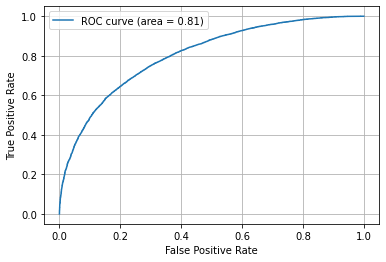

In [10]:
#create ROC curve
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

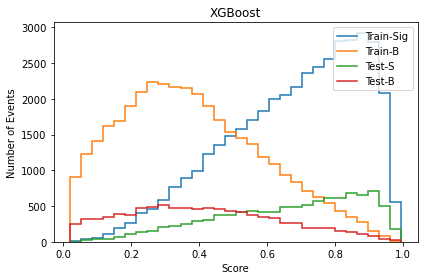

In [11]:
# Score distribution
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_signal_train, bins_sig_train = np.histogram(y_pred_train[y_train == 1], bins=30)
h_back_train, bins_back_train = np.histogram(y_pred_train[y_train == 0], bins=30)
h_sig_test, bins_sig_test = np.histogram(y_pred_test[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_test[y_test == 0], bins=30)

axs.set_title("XGBoost")
hep.histplot([h_signal_train,h_back_train, h_sig_test, h_back_test], bins_sig_test, ax=axs,label=["Train-Sig", "Train-B", "Test-S", "Test-B"])
axs.legend()
axs.set_xlabel("Score")
axs.set_ylabel("Number of Events")

plt.tight_layout()
plt.show()

## SHAP
***

In [12]:
# SHAP
start_time = time()
explainer = shap.TreeExplainer(model = model)
elapsed_time = time() - start_time
print("Elapsed time: %0.5f seconds." % elapsed_time)

Elapsed time: 5.32420 seconds.


In [ ]:
start_time = time()
shap_values = explainer.shap_values(X_test)
elapsed_time = time() - start_time
print("Elapsed time: %0.5f seconds." % elapsed_time)


In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

### Force plots
*****

In [ ]:
# Force_plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
i=0
print("XGboost prediction: %.4f" % y_pred_test[i], "label:", y_test.iloc[i])

#In binary classification, the Shapley values are displayed 
# in the logit space such that
print("::: logit() :::")
print("Explainer expected value: %.4f" % explainer.expected_value)
print("XGboost prediction: %.2f" % (shap_values[i].sum() + explainer.expected_value))
# Aplying the inverse of logit:
print("::: expit() :::")
print("XGboost prediction: %.4f" %expit(shap_values[i].sum() + explainer.expected_value))
print("Explainer expected value: %.2f" % expit(explainer.expected_value))
print("y_pred_test.mean(): %.2f" % y_pred_test.mean())

In [ ]:
print("SHAP Value m_wwwbb: %.3f" %shap_values[0,-2])
print("SHAP Value m_bb: %.3f" %shap_values[0,-3])

In [ ]:
i=102
print("XGboost prediction: %.4f" % y_pred_test[i], "label:", y_test.iloc[i])

#In binary classification, the Shapley values are displayed 
# in the logit space such that
print("::: logit() :::")
print("Explainer expected value: %.4f" % explainer.expected_value)
print("XGboost prediction: %.2f" % (shap_values[i].sum() + explainer.expected_value))
# Aplying the inverse of logit:
print("::: expit() :::")
print("XGboost prediction: %.4f" %expit(shap_values[i].sum() + explainer.expected_value))
print("Explainer expected value: %.2f" % expit(explainer.expected_value))
print("y_pred_test.mean(): %.2f" % y_pred_test.mean())
print("XGboost prediction: %.4f" % y_pred_test[i], "label:", y_test.iloc[i])

In [ ]:
# Force_plot
shap.force_plot(explainer.expected_value, shap_values[102,:], X_test.iloc[102,:])

### Summary Plots
*****

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.dependence_plot("m_wbb", shap_values,  X_test )